# Filtering out the data from 2016 to 2020

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

file_name = "../artifacts/data_ingestion/lfm_2b/listening-events.tsv"
prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
chunksize = 10**8
min_play_date = pd.to_datetime("2016-01-01 00:00:00")
columns = ["user_id", "track_id", "timestamp"]

chunk_index = 0
for chunk in pd.read_csv(file_name, sep="\t", chunksize=chunksize):
    logging.info(f"""reading from {chunk.index.min()} to {chunk.index.max()}""")
    chunk["timestamp"] = pd.to_datetime(chunk["timestamp"], format="%Y-%m-%d %H:%M:%S")
    chunk = chunk.loc[(chunk["timestamp"] >= min_play_date), :]
    if len(chunk) > 0:
        logging.info(f"""writing from {chunk.index.min()} to {chunk.index.max()}""")

        chunk_path = os.path.join(prefix_path, f"""{int(chunk_index)}.parquet""")
        chunk = chunk[columns]
        chunk.to_parquet(chunk_path, index=False)
        logging.info(f"""writing chunk to {chunk_path} finished""")
        chunk_index += 1
    logging.info(f"""#################################""")

# Step 1: Counting the number of tracks

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
track_counts = dict()

for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading and counting tracks from chunk {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)

        counts = chunk_data["track_id"].value_counts().to_dict()
        track_counts.update(counts)
track_df = pd.DataFrame(list(track_counts.items()), columns=["track_id", "count"])
track_df.head()

# Mitigating the single tracks

In [ ]:
# elimination of single tracks from chunks
logging.info(f"""Total number of tracks before elimination: {len(track_df)}""")
mask = track_df["count"] > 1
track_df = track_df.loc[mask, :]
logging.info(f"""Total number of tracks before elimination: {len(track_df)}""")

In [ ]:
import numpy as np
number_tracks = track_df["track_id"].nunique()
tracks_id_map = dict(zip(track_df["track_id"].unique(), np.arange(number_tracks)))

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
track_set = set(track_df["track_id"].unique())

new_chunk_index = 0
for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading and filtring chunk from {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)
        is_in_mask = chunk_data["track_id"].isin(track_set)
        chunk_data = chunk_data.loc[is_in_mask, :]
        if len(chunk_data) > 1:

            # for memory efficiency
            chunk_data["track_id"] = chunk_data["track_id"].map(tracks_id_map)
            chunk_data["track_id"] = chunk_data['track_id'].astype('uint32')
            chunk_data["user_id"] = chunk_data['user_id'].astype('uint32')

            new_chunk_path = os.path.join(prefix_path, f"""{int(i)}_new.parquet""")
            logging.info(f"""writing new chunk to {new_chunk_path}""")
            chunk_data.to_parquet(new_chunk_path, index=False)
            new_chunk_index += 1

# Finding data from 2016-2019

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
list_of_dataframes = []
columns = ["user_id", "track_id"]
date_2019 = pd.to_datetime("2019-01-01 00:00:00")

for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}_new.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading chunk from {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)
        mask = (chunk_data["timestamp"] < date_2019)
        chunk_data = chunk_data.loc[mask, columns]
        list_of_dataframes.append(chunk_data)

logging.info(f"""Writing data from 2016 to 2019 to""")
event_data_2016_2019 = pd.concat(list_of_dataframes, ignore_index=True)  
event_data_2016_2019.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2016_2019.parquet", index=False)

# Finding Data from 2019 to 2020

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
list_of_dataframes = []
columns = ["user_id", "track_id"]
date_2019 = pd.to_datetime("2019-01-01 00:00:00")
date_2020 = pd.to_datetime("2020-01-01 00:00:00")


for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}_new.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading chunk from {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)
        mask = (chunk_data["timestamp"] >= date_2019) & (chunk_data["timestamp"] < date_2020)
        chunk_data = chunk_data.loc[mask, columns]
        list_of_dataframes.append(chunk_data)

logging.info(f"""Writing data from 2019 to 2020 to""")
event_data_2019_2020 = pd.concat(list_of_dataframes, ignore_index=True)
event_data_2019_2020.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2019_2020.parquet", index=False)


# Transforming data into one chunk

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
list_of_dataframes = []
track_counts = dict()
columns = ["user_id", "track_id"]

for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}_new.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading chunk from {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)
        chunk_data = chunk_data[columns]
        list_of_dataframes.append(chunk_data)
        
logging.info(f"""concatinating all chunks""")
event_data = pd.concat(list_of_dataframes, ignore_index=True)
event_data.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2016.parquet", index=False)

# Creation of intraction data

### 2016 to 2019

In [ ]:
import pandas as pd
import logging
import os
import gc

logging.getLogger().setLevel(logging.INFO)

event_data_2016_2019 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2016_2019.parquet")
event_data_2016_2019['user_id'] = event_data_2016_2019['user_id'].astype('uint32')
event_data_2016_2019['track_id'] = event_data_2016_2019['track_id'].astype('uint32')

inter_2016_2019 = event_data_2016_2019.groupby(["user_id", "track_id"]).size().reset_index(name="count")
inter_2016_2019.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2016_2019.parquet", index=False)

### 2019 to 2020

In [ ]:
import pandas as pd
import logging
import os
import gc

logging.getLogger().setLevel(logging.INFO)

event_data_2019_2020 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2019_2020.parquet")
event_data_2019_2020['user_id'] = event_data_2019_2020['user_id'].astype('uint32')
event_data_2019_2020['track_id'] = event_data_2019_2020['track_id'].astype('uint32')

inter_2019_2020 = event_data_2019_2020.groupby(["user_id", "track_id"]).size().reset_index(name="count")
inter_2019_2020.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2019_2020.parquet", index=False)

# Reading intractions and performing K core Filtering

In [ ]:
def k_core_filtering(inter_data, k_item, k_user):
    logging.info(f"""Remaining items: {inter_data.track_id.nunique()}, Remaining users: {inter_data.user_id.nunique()} """)
    while True:
        start_size = len(inter_data)

        # Item pass
        track_counts = inter_data.track_id.value_counts()
        tracks_above = set(track_counts[track_counts >= k_item].index)
        inter_data = inter_data[inter_data.track_id.isin(tracks_above)]
        logging.info(f"""Remaining items: {inter_data.track_id.nunique()}, Remaining users: {inter_data.user_id.nunique()} """)

        # User pass
        user_counts = inter_data.user_id.value_counts()
        user_above = set(user_counts[user_counts >= k_user].index)
        inter_data = inter_data[inter_data.user_id.isin(user_above)]
        logging.info(f"""Remaining items: {inter_data.track_id.nunique()}, Remaining users: {inter_data.user_id.nunique()} """)
        logging.info(f"""##########################################""")

        if len(inter_data) == start_size:
            print("Exiting...")
            break
    return inter_data

### 2016 to 2019

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)
k_item = 5
k_user = 5

inter_2016_2019 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2016_2019.parquet")
inter_2016_2019 = k_core_filtering(inter_2016_2019, k_item, k_user)
inter_2016_2019.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2016_2019_filtered.parquet", index=False)

### 2019 - 2020

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)
k_item = 5
k_user = 5

inter_2019_2020 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2019_2020.parquet")
inter_2019_2020 = k_core_filtering(inter_2019_2020, k_item, k_user)
inter_2019_2020.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2019_2020_filtered.parquet", index=False)

# Filtering the Users who are in both first and second frame

In [ ]:
import pandas as pd
import logging
import os
logging.getLogger().setLevel(logging.INFO)

inter_2016_2019 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2016_2019_filtered.parquet")
inter_2019_2020 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2019_2020_filtered.parquet")

user_set_2016_2019 = set(inter_2016_2019["user_id"].unique())
user_set_2019_2020 = set(inter_2019_2020["user_id"].unique())
intersection_set = user_set_2016_2019.intersection(user_set_2019_2020)

logging.info(f"""Available items: {inter_2016_2019.track_id.nunique()}, Available users: {inter_2016_2019.user_id.nunique()} """)
mask = inter_2016_2019["user_id"].isin(intersection_set)
inter_2016_2019 = inter_2016_2019.loc[mask]
inter_2016_2019.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2016_2019_filtered.parquet")
logging.info(f"""Remaining items: {inter_2016_2019.track_id.nunique()}, Remaining users: {inter_2016_2019.user_id.nunique()} """)
logging.info("#####################################################")

logging.info(f"""Available items: {inter_2019_2020.track_id.nunique()}, Available users: {inter_2019_2020.user_id.nunique()} """)
mask = inter_2019_2020["user_id"].isin(intersection_set)
inter_2019_2020 = inter_2019_2020.loc[mask]
inter_2019_2020.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2019_2020_filtered.parquet")
logging.info(f"""Remaining items: {inter_2019_2020.track_id.nunique()}, Remaining users: {inter_2019_2020.user_id.nunique()} """)


# Selecting 100_000 tracks randomly 

In [ ]:
import pandas as pd
import numpy as np
import logging
logging.getLogger().setLevel(logging.INFO)

rng = np.random.RandomState(42)
sampled_items = 100000

inter_2016_2019 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2016_2019_filtered.parquet")
inter_2019_2020 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/inter_2019_2020_filtered.parquet")

inter_2016_2019.rename(columns={"user_id":"user", "track_id":"item", "count":"rating"}, inplace=True)
inter_2019_2020.rename(columns={"user_id":"user", "track_id":"item", "count":"rating"}, inplace=True)

logging.info(f"""from 2016 to 2019 before sampling: #items: {inter_2016_2019.item.nunique()}, #users: {inter_2016_2019.user.nunique()} """)
logging.info(f"""from 2019 to 2020 before sampling: #items: {inter_2019_2020.item.nunique()}, #users: {inter_2019_2020.user.nunique()} """)


item_ids =  inter_2016_2019["item"].unique()
rng.shuffle(item_ids)
sampled_track_ids = item_ids[:sampled_items]

sub_inter_2016_2019 = inter_2016_2019[inter_2016_2019.item.isin(set(sampled_track_ids))]
sub_inter_2019_2020 = inter_2019_2020[inter_2019_2020.item.isin(set(sampled_track_ids))]

sample_users = set(sub_inter_2016_2019["user"].unique()).intersection(sub_inter_2019_2020["user"].unique())

sub_inter_2019_2020 = sub_inter_2019_2020[sub_inter_2019_2020.user.isin(sample_users)]
sub_inter_2016_2019 = sub_inter_2016_2019[sub_inter_2016_2019.user.isin(sample_users)]

logging.info(f"""from 2016 to 2019 after sampling: #items: {sub_inter_2016_2019.item.nunique()}, #users: {sub_inter_2016_2019.user.nunique()} """)
logging.info(f"""from 2019 to 2020 after sampling: #items: {sub_inter_2019_2020.item.nunique()}, #users: {sub_inter_2019_2020.user.nunique()} """)

sub_inter_2016_2019.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/sample_inter_2016_2019_filtered.parquet")
sub_inter_2019_2020.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/sample_inter_2019_2020_filtered.parquet")

# Analyzing the Dataset

In [1]:
import pandas as pd
import logging 
logging.getLogger().setLevel(logging.INFO)

inter_2016_2019 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/sample_inter_2016_2019_filtered.parquet")
inter_2019_2020 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/sample_inter_2019_2020_filtered.parquet")

logging.info(f"""from 2016 to 2019: #items: {inter_2016_2019.item.nunique()}, #users: {inter_2016_2019.user.nunique()} """)
logging.info(f"""from 2019 to 2020: #items: {inter_2019_2020.item.nunique()}, #users: {inter_2019_2020.user.nunique()} """)

all_inter = pd.concat([inter_2016_2019, inter_2019_2020], ignore_index=True)
all_inter = all_inter.drop_duplicates(subset=["user", "item"], keep="last")


INFO:root:from 2016 to 2019: #items: 100000, #users: 16248 
INFO:root:from 2019 to 2020: #items: 42952, #users: 16248 


In [2]:
from tools import create_user_item_map
from tools import generate_user_item_matrix
from tools import group_items_based_popularity
from tools import calc_item_popularity

user_map, item_map = create_user_item_map(all_inter)
sparse_matrix = generate_user_item_matrix(all_inter, user_map, item_map)
item_popularity = calc_item_popularity(sparse_matrix)
item_groups = group_items_based_popularity(item_popularity, proportions=[0.2, 0.6, 0.2])

In [3]:
train_user_item_ordered = generate_user_item_matrix(inter_2016_2019, user_map, item_map)
valid_user_item_ordered = generate_user_item_matrix(inter_2019_2020, user_map, item_map)

display(train_user_item_ordered.shape)
display(valid_user_item_ordered.shape)

(16248, 100000)

(16248, 100000)

In [4]:
from reylearn.metrics.probability import jsd, kl_divergence
from tools import calculate_pc

p_c_ordered = calculate_pc(train_user_item_ordered.toarray(), item_groups)
q_c_ordered = calculate_pc(valid_user_item_ordered.toarray(), item_groups)

user_jsd_ordered = jsd(p_c_ordered, q_c_ordered)
user_jsd_ordered

array([0.14268438, 0.04134386, 0.24586869, ..., 0.00925227, 0.        ,
       0.12376469], shape=(16248,))

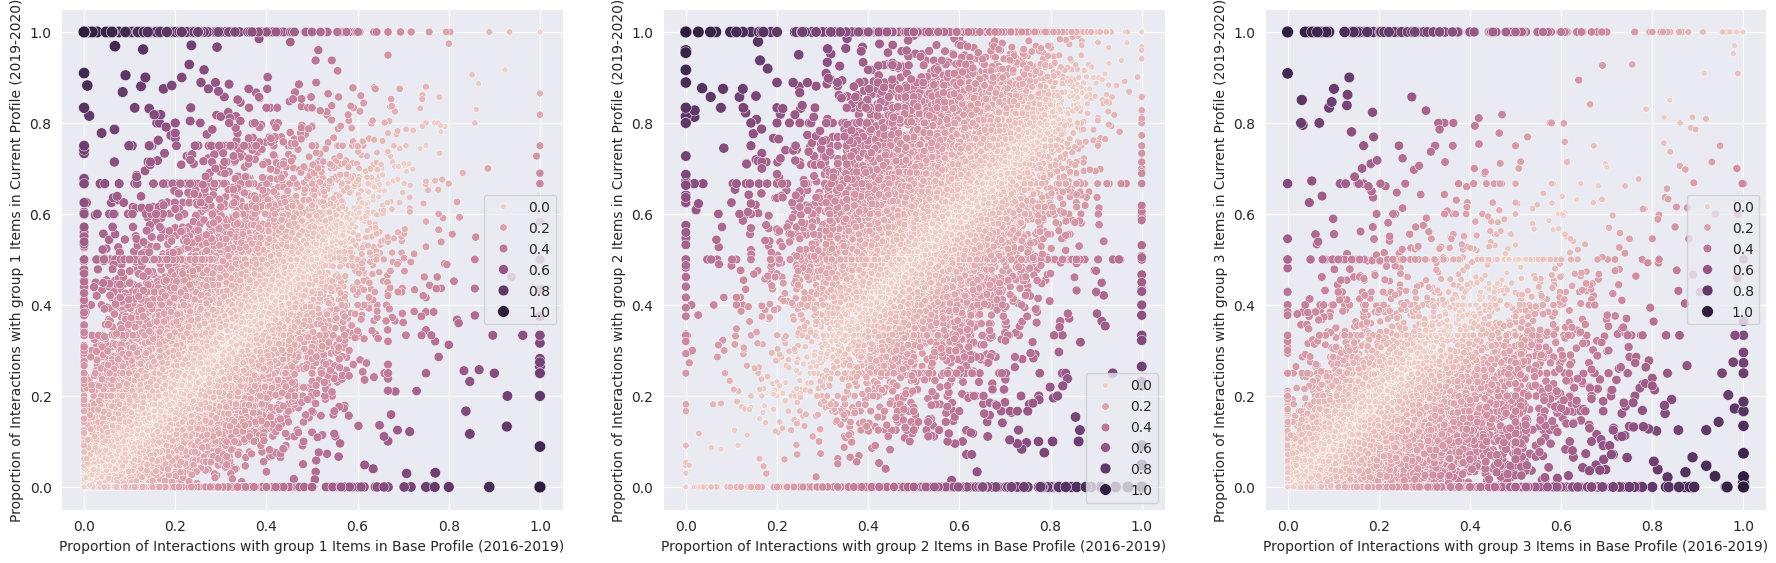

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 3, figsize=(22, 6.5))
    for i in range(3):
        ax = axes[i]
        diff_ordered = np.abs(p_c_ordered[:, i] - q_c_ordered[:, i])
        sns.scatterplot(x=p_c_ordered[:, i], y=q_c_ordered[:, i], size=diff_ordered, hue=diff_ordered, ax=ax)
        
        label_x = f"Proportion of Interactions with group {i+1} Items in Base Profile (2016-2019)"
        label_y = f"Proportion of Interactions with group {i+1} Items in Current Profile (2019-2020)"
        
        ax.set_xlabel(label_x)
        ax.set_ylabel(label_y)


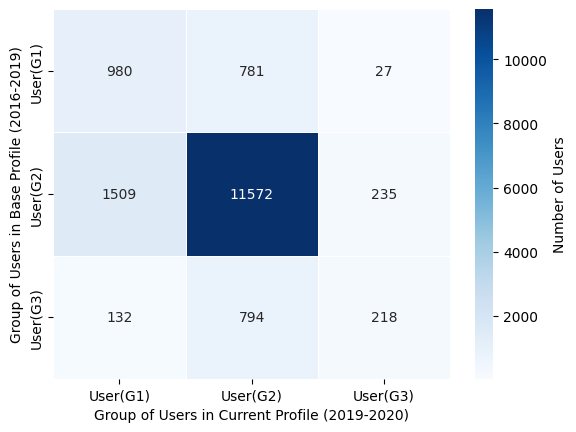

In [12]:
user_consumption_type_before = np.argmax(p_c_ordered, axis=1)
user_consumption_type_after = np.argmax(q_c_ordered, axis=1)

n_groups = p_c_ordered.shape[1]
transition_matrix = np.zeros((n_groups, n_groups), dtype=int)

for i in range(n_groups):
    for j in range(n_groups):
        count = np.sum((user_consumption_type_before == i) & (user_consumption_type_after == j))
        transition_matrix[i, j] = count

group_labels = ["User(G1)", "User(G2)", "User(G3)"]
df_transition = pd.DataFrame(transition_matrix, index=group_labels, columns=group_labels)


sns.heatmap(df_transition, annot=True, fmt="d", cmap="Blues", linewidths=0.5, cbar_kws={"label": "Number of Users"})

plt.ylabel("Group of Users in Base Profile (2016-2019)")
plt.xlabel("Group of Users in Current Profile (2019-2020)")

plt.show()